In [20]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import Model
from math import log, sqrt, exp, erf, ceil
from tqdm.notebook import tqdm, trange
import pandas as pd
from math import ceil

import scipy.stats as stats
from scipy.stats import qmc
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 7)
plt.style.use('bmh')

# Quasi Monte Carlo Normal Distribution

In [21]:
from scipy.stats import norm
import math

def bs_put(S, K, T, r, sigma):
    d1 = (log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)

    """ negative in front - negative in front of d1 """
    # D = - (1.0 + erf(-d1 / sqrt(2.0))) / 2.0
    # V = S*D + K*exp(-r*T)* (1.0 + erf(-d2 / sqrt(2.0))) / 2.0

    d1 = (math.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    call_price = S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)

    return call_price

def sobol_norm(m, d=1):
    sampler = qmc.Sobol(d, scramble=True)
    x_sobol = sampler.random_base2(m)
    return stats.norm.ppf(x_sobol)

Number of steps: 2
mean St   = 1.083286
e^(r * T) = 1.083287 
|Diff|    = 0.000001


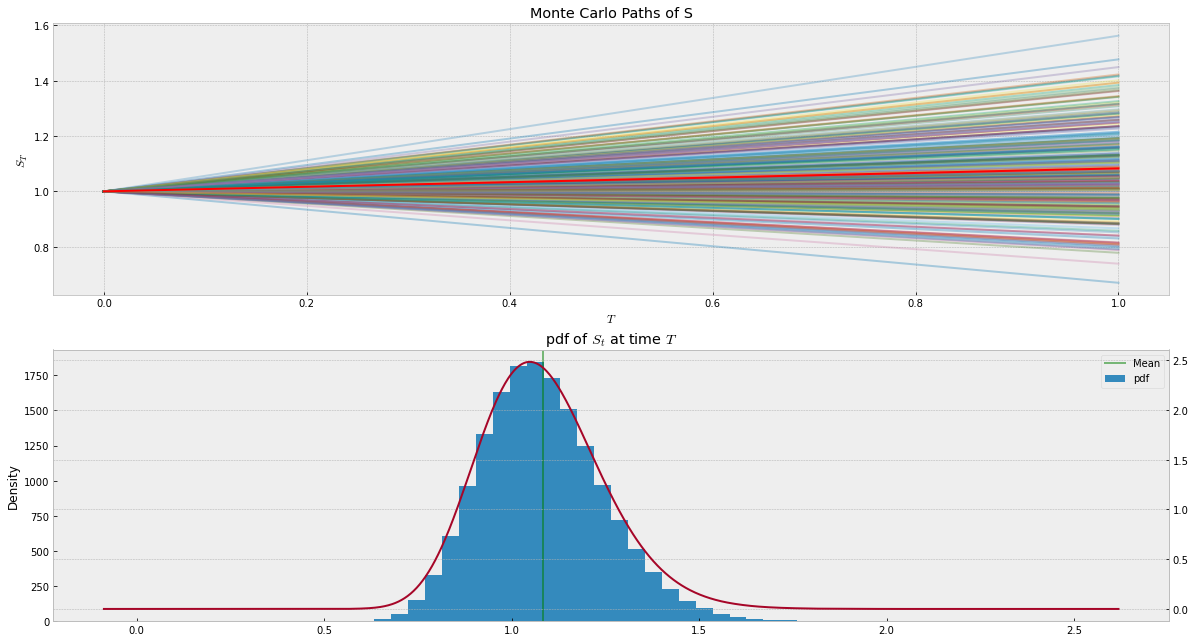

Discounted E[V] - Call = 0.1039
Discounted E[V] - Put  = 0.0270


In [22]:
# %%timeit # 15.5 ms ± 870 µs per loop
n_paths   = ceil(np.log2(10_000))

S       = 1
K       = 1
T       = 1.0
r       = .08
sigma   = 0.15
dt      = 1/1

n_time_steps = int(T/dt) +1 ; print(f'Number of steps: {n_time_steps}')

""" Simulate Stock Data """
W       = sobol_norm(n_paths, d=n_time_steps)
S_paths = np.empty((2**n_paths, n_time_steps))
S_paths[:,0] = S
for t in range(1,n_time_steps):
    S_paths[:,t] = (S_paths[:,t-1] * np.exp((r-sigma**2/2)*dt + sigma * np.sqrt(dt)*W[:,t] ).squeeze())

""" Generate Bond Data """
B = np.exp(r*np.linspace(0,T, n_time_steps))
B = np.broadcast_to(B, S_paths.shape)

fig, axs = plt.subplots(2, figsize=(20,11))
print(f'mean St   = {S_paths[:,t].mean():.6f}')
print(f'e^(r * T) = {S*np.exp(r*T):.6f} \n|Diff|    = {abs(np.nanmean(S_paths[:,-1])-S*np.exp(r*T)):.6f}')
rdf = pd.DataFrame(S_paths.T, index=(np.linspace(0,T, n_time_steps)))
rdf.sample(300, axis=1).plot(legend=False, alpha=.3, ylabel=r'$S_T$', xlabel=r'$T$', ax=axs[0], title='Monte Carlo Paths of S') 
axs[0].plot(np.linspace(0,T, n_time_steps), S*np.exp(r*np.linspace(0,T, n_time_steps)), c='r')

rdf.iloc[-1,:].hist(bins=30, ax=axs[1])
rdf.iloc[-1,:].plot(kind='kde', secondary_y=True, title=r'pdf of $S_t$ at time $T$', xlabel=r'S_T', ylabel='Density over 10,000 paths', ax=axs[1])
axs[1].axvline(S_paths[:,t].mean(), color='g', linestyle='-', alpha=.5)
axs[1].legend(['Mean', 'pdf'])
plt.show()
print(f'Discounted E[V] - Call = {np.maximum(S_paths[:,-1] - K, 0).mean() * np.exp(-r*T):.4f}')
print(f'Discounted E[V] - Put  = {np.maximum(K - S_paths[:,-1], 0).mean() * np.exp(-r*T):.4f}')

# Defining the Neural Network

In [23]:
""" Calculate: Payoff for Options """
Type = 'Call' # or put
payoff = np.maximum(S_paths[:,-1] - K, 0) if Type == 'Call' else np.maximum(K - S_paths[:,-1], 0)
payoff.mean()
# payoff = np.where(S_paths[:,-1] > K, S_paths[:,-1], K)

0.11254838008588469

In [25]:
def scheduler(epoch, lr):
    if epoch < 100 :
        return 1e-2
    elif epoch < 200 :
        return 1e-3
    elif epoch < 400 :
        return 5e-4
    else:
        return lr

rl_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

In [26]:
dense_initalizer = keras.initializers.RandomNormal(mean=0, stddev=0.01, seed=1234)
const_initalizer = 'zeros' #keras.initializers.RandomNormal(mean=[1-out_of_money_P,out_of_money_P], stddev=0.0, seed=1234)
# const_initalizer = 'zeros' #keras.initializers.Constant(0)

Input_S = keras.Input(shape=(1,), name='input: S_{t} ') # LeakyReLU
x = keras.layers.Dense(12, activation='LeakyReLU', name='LeakyReLU_1', kernel_initializer=dense_initalizer)(Input_S)
# x = keras.layers.Dense(8, activation='LeakyReLU', name='LeakyReLU_2', kernel_initializer=dense_initalizer)(x)
holdings = keras.layers.Dense(2, activation='linear', name='Phi_Psi', kernel_initializer=dense_initalizer, bias_initializer=const_initalizer)(x)

prices_1 = keras.Input(shape=(2,), name='input: S_{t}, B_{t} ')
value    = keras.layers.Dot(axes = 1, name='V_t')([holdings, prices_1]) 

model = keras.Model(inputs=[Input_S, prices_1], outputs=value, name="Replicating_Portfolio")
# model.summary()
#------------------------#------------------------#------------------------#------------------------#------------------------#------------------------#------------------------
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)
model.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-3),
              loss = "mse", run_eagerly=False, 
              metrics=["mae", "mape"])

values          = np.empty((payoff.shape[0], S_paths.shape[1]))
values[:,-1]    = S
print(values[:,-1].min())
""" Calculate: Payoff for Options """
Flag = True ; its = 0
Errors      = np.zeros((1,2))
P_E_Values  = np.ones((1,3)) * payoff.mean()
for t_i in trange(n_time_steps-2, -1, -1):
    _Y_t  = S_paths[:,t_i]
    _B_t  = B[:,t_i]
    _Y_t1 = S_paths[:,t_i+1]
    _B_t1 = B[:,t_i+1]

    X0 = [_Y_t, np.stack((_Y_t, _B_t), axis=-1)]
    X1 = [_Y_t, np.stack((_Y_t1, _B_t1), axis=-1)]

    epochs = 300
    if Flag :
        print(f'Payoff.mean: {payoff.mean():.5f}\nPredic.mean: {model.predict(X0, verbose=0, batch_size=512).squeeze().mean():.5f}')
        callabacks = [rl_scheduler, keras.callbacks.EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)]
        Flag = False 
    else : 
        epochs = 20 
        callabacks = [callback]

    model.fit(X1, values[:,t_i+1], epochs=epochs, validation_split=0.0, verbose=0, batch_size=512, callbacks=callabacks) #, initial_epoch= 200 if t_i != n_time_steps-2 else 0)
    # print(f'S.mean: {S.mean():.5f}\nP.mean: {model.predict(X0, verbose=0, batch_size=512).squeeze().mean():.5f}')
    values[:,t_i] = model.predict(X0, verbose=0, batch_size=512).squeeze()

    Errors = np.append(Errors, np.array(model.evaluate(X1, values[:,t_i+1], batch_size=512)[1:]).reshape(1,2), axis=0) ; its += 1
    # P_E_Values = np.append(P_E_Values, np.array([values[:,t_i].mean(), payoff.mean()*np.exp(-mu*dt*its), S.mean()*np.exp(-r*dt*its)]).reshape(1,3), axis=0)


1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Payoff.mean: 0.11255
Predic.mean: -0.00005


2023-03-24 18:56:50.007227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-03-24 18:56:50.189099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-03-24 18:57:10.010026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step - loss: 1.4463e-16 - mae: 1.9827e-09 - mape: 1.9827e-07


2023-03-24 15:44:25.891363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Mean Phi : -1.8970 
Mean Psi : 1.6529


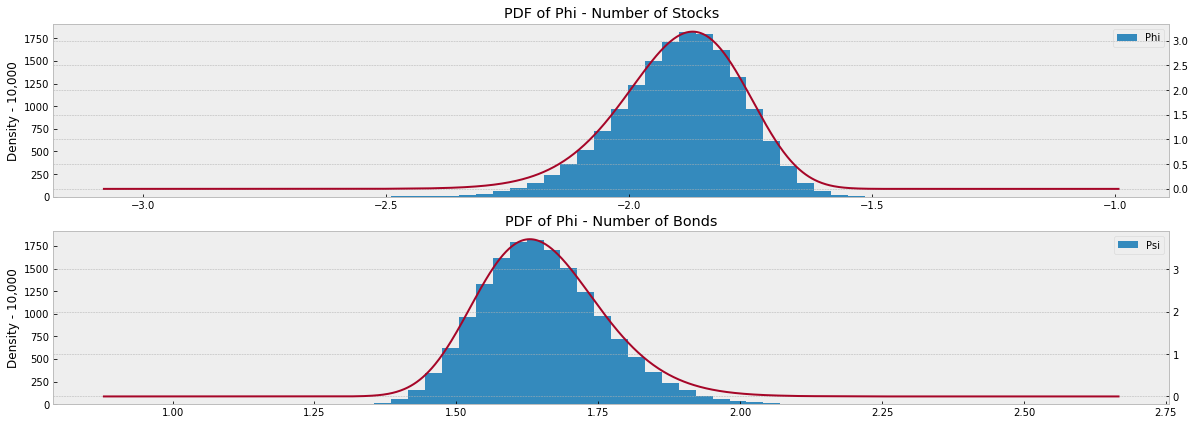

In [17]:
layer_output=model.get_layer('linear').output
pw_model = Model(inputs=[model.input], outputs=[layer_output])

t_i = 1
_ = np.stack((S_paths[:,t_i], B[:,t_i]), axis=-1)
X0 = [S_paths[:,t_i], _]
linear_layer_output = pw_model.predict(X0)
Phi, Psi = linear_layer_output[:,0], linear_layer_output[:,1]

data = {'Phi': Phi, 'Psi': Psi}
HP = pd.DataFrame.from_dict(data)

fig, axs = plt.subplots(2)
HP['Phi'].plot(kind='hist', bins=30, ax=axs[0], title='PDF of Phi - Number of Stocks')
HP['Phi'].plot(kind='kde', ax=axs[0], secondary_y=True)
HP['Psi'].plot(kind='hist', bins=30, ax=axs[1], title='PDF of Phi - Number of Bonds')
HP['Psi'].plot(kind='kde', ax=axs[1], secondary_y=True)
axs[0].set_ylabel('Density - 10,000') ; axs[0].legend() ; axs[1].set_ylabel('Density - 10,000') ;axs[1].legend()
print(f'Mean Phi : {HP["Phi"].mean():.4f} \nMean Psi : {HP["Psi"].mean():.4f}')


# Plot

Value at t_0 (Blach-Scholes) = 0.10390
Value at t_0 (Replicating-P) = 0.10619
Discounted Payoff            = 0.10389


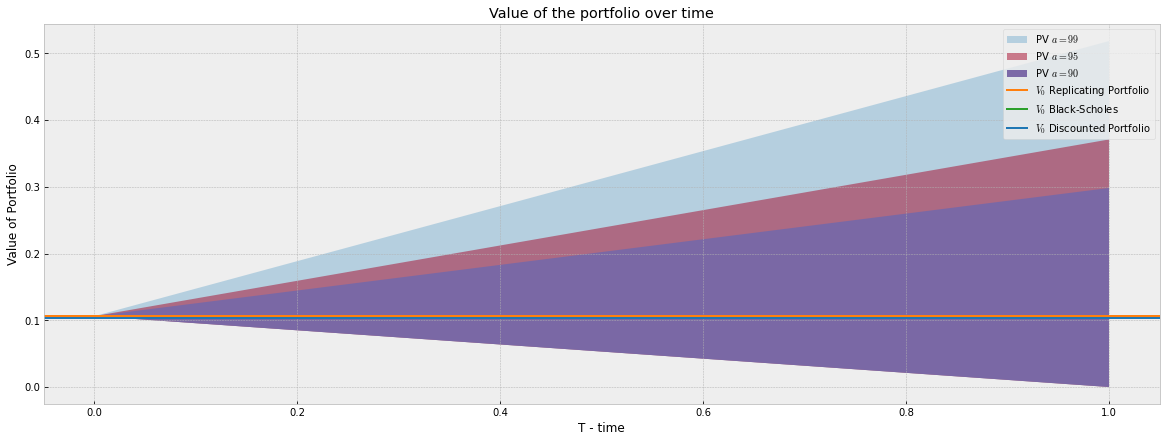

In [18]:
V0_RP = values[:,0].mean()
# std_mean = values.reshape(128, -1, n_time_steps).mean(axis=0).std(ddof=1)
# V0_RP_SE = std_mean / np.sqrt(128)
V0_BS = bs_put(S, K, T, r, sigma)
qs = np.quantile(values, q=[.99, .95, .9, .1, .05, .01], axis=0)
t  = np.linspace(0, T, n_time_steps)

fig, ax = plt.subplots()
ax.fill_between(t, qs[0,:].squeeze(), qs[-1,:].squeeze(), alpha=.3)
ax.fill_between(t, qs[1,:].squeeze(), qs[-2,:].squeeze(), alpha=.5)
ax.fill_between(t, qs[2,:].squeeze(), qs[-3,:].squeeze(), alpha=.99)
# pd.DataFrame(Errors[::-1], index=t, columns=['Error']).plot(legend=False, color='tab:red', ax=ax) #, secondary_y=True, 
ax.axhline(V0_RP, color='tab:orange')
ax.axhline(V0_BS, color='tab:green')
ax.axhline(payoff.mean() * np.exp(-r*T), color='tab:blue')
ax.legend([r'PV $a=99$',r'PV $a=95$',r'PV $a=90$', r'$V_0$ Replicating Portfolio', r'$V_0$ Black-Scholes', r'$V_0$ Discounted Portfolio'])
ax.set_xlabel('T - time') ; ax.set_ylabel('Value of Portfolio') ; ax.set_title('Value of the portfolio over time')

print(f'Value at t_0 (Blach-Scholes) = {V0_BS:.5f}')
print(f'Value at t_0 (Replicating-P) = {V0_RP:.5f}')
print(f'Discounted Payoff            = {payoff.mean() * np.exp(-r*T):.5f}')
# print(f'Replicating-P : 2σ = {V0_RP_SE:.4f}')

# Tune Architecture

In [19]:
# Todo: Write code for tuning the HP of the NN